In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger, save_exper
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_loss_over_tsteps, plot_exper_losses, plot_parm_loss_steps
from utils.plots import plot_qt_mode_hist, plot_qt_detailed_stats
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [# Meta V3 model regression
                  (False, "run_20170713_08_40_49_metaV3_10ep_100ops_lr5e04_adam"), # 
                  (True, "run_20170713_16_12_22_metaV3.1_10ep_100ops_lr1e04_adam"),  # nu=0.3, 10 epochs
                  (True, "run_20170713_16_39_30_metaV3.2_10ep_100ops_retrain_lr1e04_adam")] # uniform, 12 epochs




In [3]:
without_models = True

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exp = get_experiment(exp_path[1])
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        if explogger is None:
            explogger = create_logger(exp, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exp))
        new_experiments[-1].reset_val_stats()


0 Loading model metaV3.1_regression_100ops / run_20170713_16_12_22_metaV3.1_10ep_100ops_lr1e04_adam


INFO - Successfully saved fig figures/10_dim_compare_metaV1_actV2_fixed_stoch_100steps_11_40_45.png


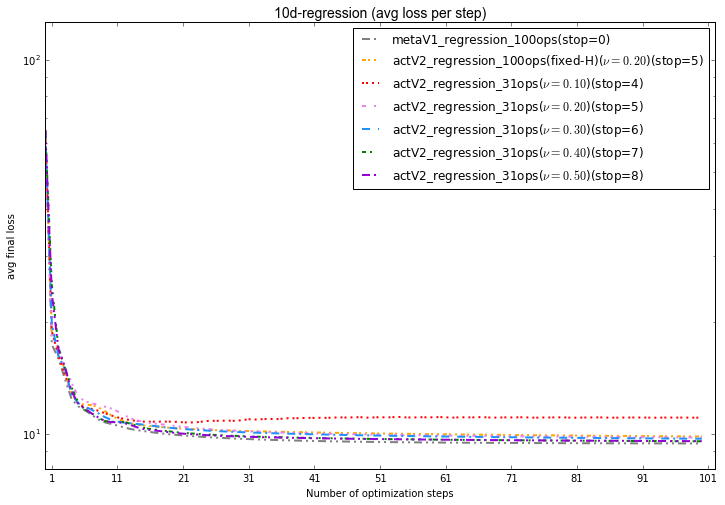

In [10]:
# new_exp_only = [new_experiments[5], new_experiments[6], new_experiments[7]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10_dim_compare_metaV1_actV2_fixed_stoch_100steps", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=100,
                                              sort_exper="10d-regression",
                                              log_scale=True,
                                              with_stddev=False,
                                              runID=None)

[2, 4, 6, 8, 10]
[1138.1333379745483, 1111.8029174804688, 1117.6416606903076, 1078.5239105224609, 1090.6906070709229]
INFO - Successfully saved fig logs/run_20170713_16_12_22_metaV3.1_10ep_100ops_lr1e04_adam/loss_metaV3.1_10ep_100ops_16:30:40.png


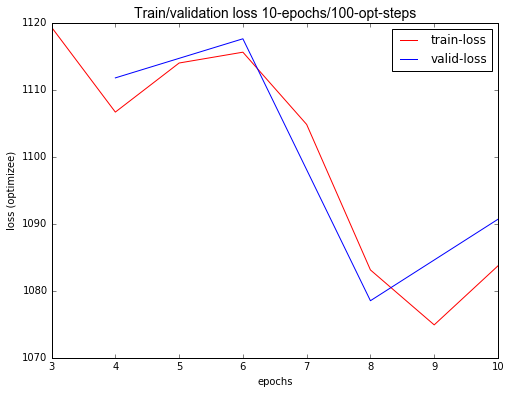

In [6]:
loss_plot(experiments[0], loss_type="loss", save=True, validation=True, show=True)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [3]:
val_funcs = RegressionFunction(n_funcs=15000, n_samples=10, stddev=1.0, 
                             x_dim=10, use_cuda=True)
with open("data/val_funcs_15000_10_1.0_10.dll", 'wb') as f:
     dill.dump(val_funcs, f)
print("Success")

Success


In [4]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 20000
            val_funcs = L2LQuadratic(batch_size=num_of_val_funcs, num_dims=10, stddev=0.01, use_cuda=True)
print("Ready")

Ready


In [87]:
with open("data/val_funcs_20000_10_1.0_10.dll", 'rb') as f:
    val_funcs = dill.load(f)
print("Success")

Success


In [6]:
test_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1., 
                             x_dim=10, use_cuda=True, calc_true_params=False)
with open("data/test_funcs_20000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [4]:
with open("data/test_funcs_20000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


In [5]:
print(len(new_experiments))
exp_idx = 1
max_steps = 100
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=True, save_run="test20000")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model actV2_regression_31ops with 20000 functions


2
Validating model actV2_regression_31ops with q-prob 0.400


INFO - INFO - Epoch 400, elapsed time 20.65 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 1.085e+03/9.581/0.3919
INFO - INFO - Epoch 400: Final validation average ACT-loss: 14.92
INFO - INFO - Epoch 400: Average stopping-step: 7
INFO - INFO - Epoch 400: Final step losses: [ 64.786  25.101  17.064  15.007  13.351  12.197  11.655  11.403  11.105
  10.863  10.796  10.81   10.784  10.675  10.53   10.411  10.333  10.281
  10.23   10.179  10.131  10.094  10.061  10.034  10.006   9.983   9.959
   9.941   9.922   9.907   9.89    9.878   9.863   9.852   9.84    9.831
   9.819   9.811   9.801   9.794   9.785   9.779   9.77    9.764   9.756
   9.752   9.744   9.74    9.733   9.729   9.722   9.719   9.712   9.709
   9.703   9.7     9.695   9.692   9.686   9.684   9.679   9.677   9.671
   9.67    9.665   9.663   9.658   9.657   9.652   9.651   9.646   9.645
   9.64    9.639   9.635   9.634   9.63    9.629   9.625   9.624   9.62
   9

INFO - Successfully saved experimental details to logs/run_20170711_08_40_14_actV2_30ep_31ops_retrain_lr5e05_adam/exp_statistics_test20000.dll


In [5]:
del new_experiments
new_experiments = []

for exper in expers_to_load:
    if exper[0]:
        new_experiments.append(get_experiment(path_to_exp=exper[1] + "/" + "exp_statistics_test20000.dll",
                                              full_path=True))
print("Ready")

Ready


In [16]:
del new_experiments[0]


('Key ', 100)
INFO - Successfully saved fig logs/run_20170711_08_40_14_actV2_30ep_31ops_retrain_lr5e05_adam/qt_T_dist_val_actV2_30ep_31ops_retrain.png


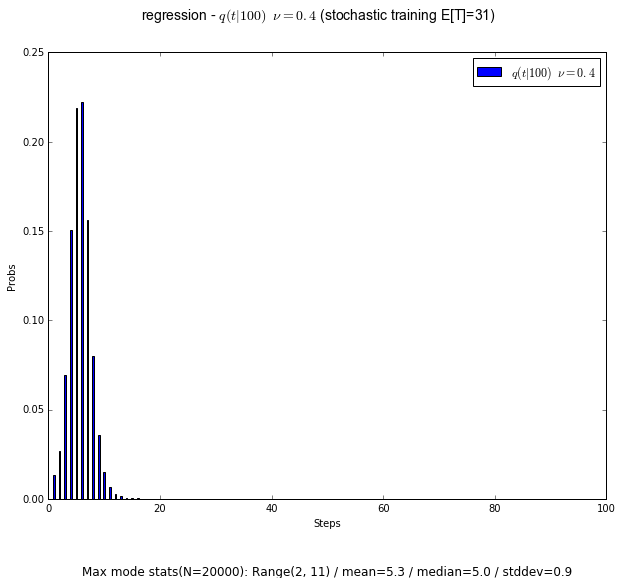

In [5]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [122]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

('key ', 100)


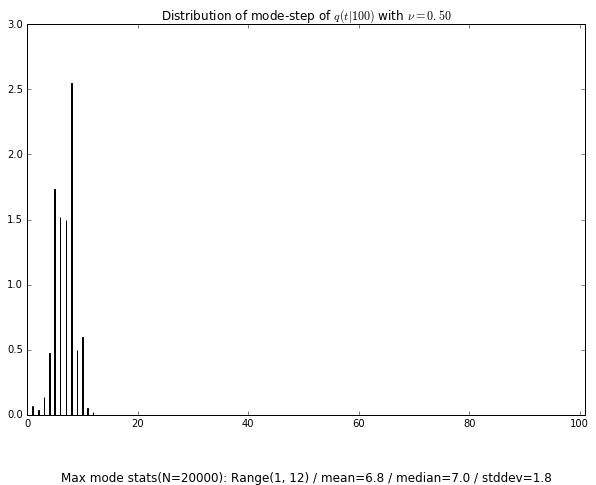

In [23]:
plot_qt_mode_hist(new_experiments[1], do_save=False, do_show=True, add_info=True)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


Run with key 100
INFO - Successfully saved fig logs/run_20170711_08_40_14_actV2_30ep_31ops_retrain_lr5e05_adam/qt_detailed_stats_actV2_30ep_31ops_retrain.png


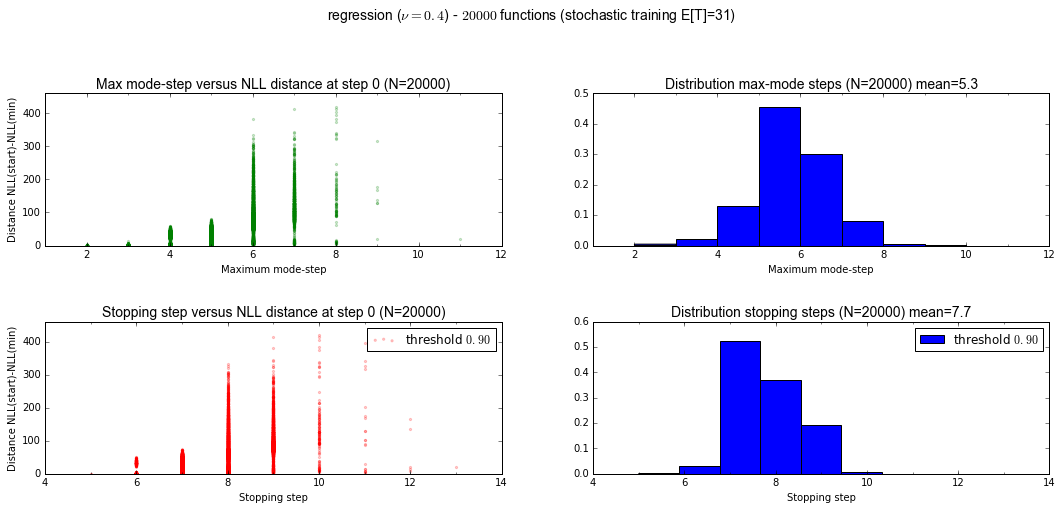

In [8]:
plot_qt_detailed_stats(new_experiments[2], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [9]:
# stops = np.cumsum(q_probs, 1)[:, -2] > threshold
q_probs = new_experiments[5].val_stats["qt_funcs"][100]
threshold = 0.95
stops = np.cumsum(q_probs, 1)[:, -2] > threshold

In [11]:
stops[0:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)